In [2]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import cm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
from jupyterthemes import jtplot

In [3]:
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(12, 8))
init_notebook_mode(connected=True)

### Reload Rules

In [4]:
with pd.HDFStore('rules.h5') as store:
    rules = store.rules
rules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 0 to 617
Data columns (total 9 columns):
itemset               618 non-null object
antecedent            618 non-null object
consequent            618 non-null object
support_rule          618 non-null float64
support_antecedent    618 non-null float64
support_consequent    618 non-null float64
confidence            618 non-null float64
lift                  618 non-null float64
pvalue                618 non-null float64
dtypes: float64(6), object(3)
memory usage: 48.3+ KB


### Create Rule Labels

In [5]:
def create_rule_label(df, item_id):
    antecedent = df.antecedent.apply(
        lambda x: '{' + ', '.join(item_id[i] for i in x) + '}')
    consequent = df.consequent.apply(
        lambda x: '{' + ', '.join(item_id[i] for i in x) + '}')
    return antecedent.str.cat(consequent, sep=' => ')

### Reload Data 

In [40]:
def get_transaction_data():
    """Load groceries transaction data into DataFrame"""
    df = pd.read_csv('grocery_transactions.csv')
    df = df.stack().reset_index(-1, drop=True)
    df.index.names = ['tx_id']
    return pd.get_dummies(df, prefix='', prefix_sep='').groupby(level='tx_id').sum()

data = get_transaction_data()
item_id = pd.Series(dict(enumerate(data.columns)))

In [41]:
rules['rule'] = create_rule_label(rules, item_id)
rules[['rule', 'support_rule', 'confidence', 'lift', 'pvalue']].sort_values('lift', ascending=False).head()

,rule,support_rule,confidence,lift,pvalue
461,"{whole milk, yogurt} => {curd}",0.010067,0.179673,3.371961,2.031197e-28
456,"{curd} => {whole milk, yogurt}",0.010067,0.188931,3.371961,2.031197e-28
438,"{root vegetables} => {other vegetables, citrus...",0.010372,0.095149,3.294710,6.350045e-30
443,"{other vegetables, citrus fruit} => {root vege...",0.010372,0.359155,3.294710,6.350045e-30
562,"{yogurt, other vegetables} => {whipped/sour cr...",0.010169,0.234192,3.266730,9.773200e-28


### Bonferroni Adjustment

In [42]:
len(rules)

618

In [48]:
n_candidates = 3828 + 16215 + 3060
bonferroni_threshold = 0.05 / n_candidates
significant_rules = rules[rules.pvalue < bonferroni_threshold]
len(significant_rules)

428

In [44]:
significant_rules.describe()

,support_rule,support_antecedent,support_consequent,confidence,lift,pvalue
count,428.000000,428.000000,428.000000,428.000000,428.000000,4.280000e+02
mean,0.016936,0.114453,0.114453,0.215640,1.950758,7.652031e-08
std,0.008951,0.075529,0.075529,0.138909,0.424745,2.994811e-07
min,0.010067,0.017287,0.017287,0.039395,1.204909,1.718405e-83
25%,0.011287,0.053285,0.053285,0.103333,1.619611,8.250549e-24
50%,0.013830,0.093960,0.093960,0.176004,1.843841,1.206510e-16
75%,0.019727,0.193512,0.193512,0.318112,2.203130,7.296719e-11
max,0.074842,0.255542,0.255542,0.586207,3.371961,2.138576e-06


### Plot rules in Confidence-Lift space

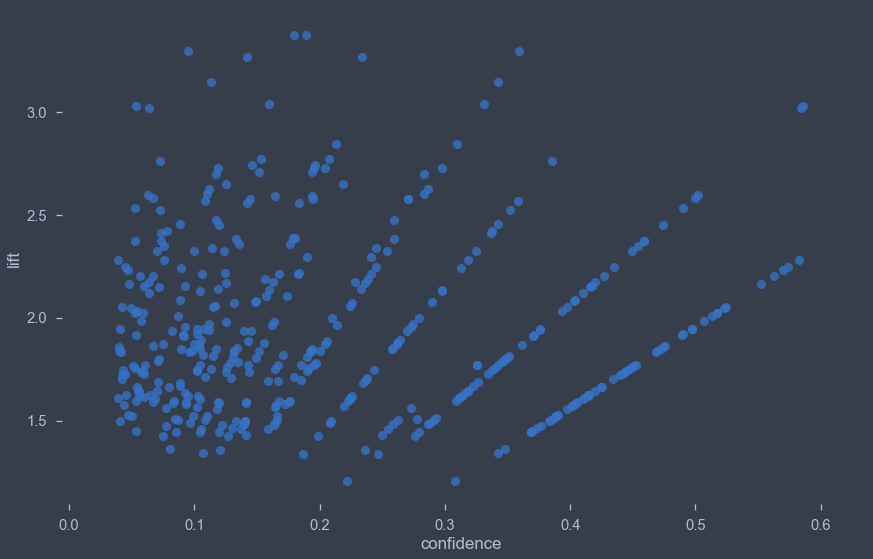

In [45]:
sns.lmplot(data=significant_rules, x='confidence', y='lift', 
           fit_reg=False)
plt.gcf().set_size_inches(15, 9);

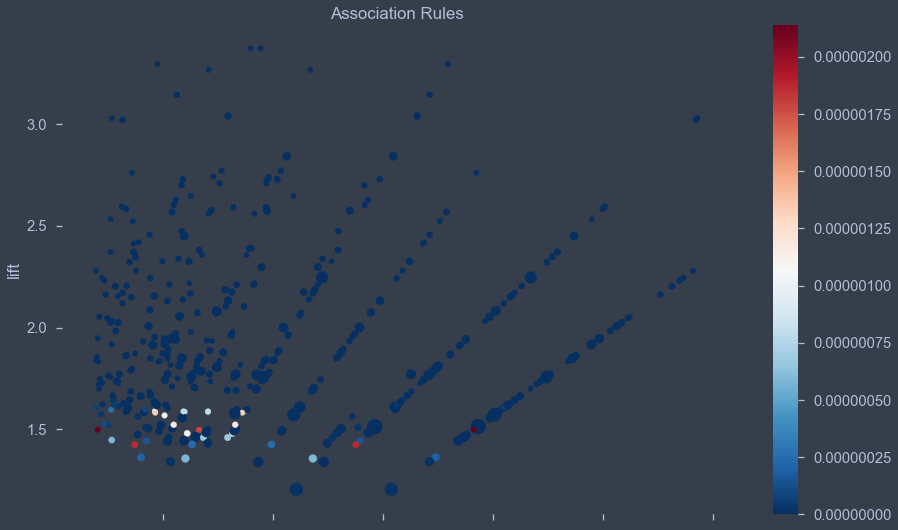

In [46]:
cmap = cm.get_cmap('RdBu_r')
significant_rules.plot.scatter(x='confidence', 
                   y='lift', 
                   s=significant_rules.support_rule.mul(3000), 
                   c=significant_rules.pvalue, 
                   cmap=cmap, 
                   title='Association Rules', 
                   figsize=(15, 9));

### Interactive Visualization with Plotly 

In [47]:
fig = dict(
    data=[
        dict(
            type='scatter',
            x=significant_rules.confidence,
            y=significant_rules.lift,
            legendgroup="group",
            text=rules.rule,
            mode='markers',
            marker=Marker(
                size=significant_rules.support_rule,
                sizemode='area',
                sizeref=significant_rules.support_rule.max() / 8,
                sizemin=4,
                cmin=significant_rules.pvalue.min(),
                cmax=significant_rules.pvalue.max(),
                color=significant_rules.pvalue,
                showscale=True,
                opacity=.5,
                colorbar=ColorBar(
                    title='p-Value'
                ),
                line=dict(width=1))),
    ],
    layout=dict(title='Association Rules',
                width=1200,
                font=dict(color='white'),
                xaxis=dict(title='Confidence',
                           hoverformat='.1%',
                           tickformat='.0%'),
                yaxis=dict(title='Lift',
                           hoverformat='.2f'),
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)'
                ))

iplot(fig, show_link=False)